## Test on Bebinca (WP142024)

With EarthCARE (01078B) and SAR

For Bebinca, there are 2 useful SAR images, much before and much after the EarthCARE frame, so maybe interpolate the Kepert parameters to obtain the most accurate wind field.

In [13]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from pyproj import CRS, Geod

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [14]:
# Paths & Params
PTHS = {
    'iwp_dir': '/home/arthur/data/tropical_cyclones/IWRAP/',
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    # 'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/02_plotKepertAndSARasymmetries/',
}

In [15]:
# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

# Open TC
ds0  = dsg.where(dsg.name == 'BEBINCA', drop=True).sortby('time').isel(time=6)
dsp0 = xr.open_dataset(PTHS['sar_dir'] + 'rcm3-sc50mc-owi-ca-20240914t212800-20240914t212918-00003-______sw_wp142024_cyclone_polar.nc').isel(time=0)

ds  = dsg.where(dsg.name == 'BEBINCA', drop=True).sortby('time').isel(time=7)
dsp = xr.open_dataset(PTHS['sar_dir'] + 'rcm3-sc50mc-owi-ca-20240915t094727-20240915t094845-00003-______sw_wp142024_cyclone_polar.nc').isel(time=0)

In [20]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2001 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, :])[0] # meteRs
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / abs(K * ((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * eta(Rs, Vs, K, C, fcor) + 3j * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * psi(Rs, Vs, K, C, fcor) + 3j * eta(Rs, Vs, K, C, fcor)]
    return num / den

def A1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 - 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 + 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 - 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 - 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 + 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

# Thicknesses
def delta0(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor)))

def delta1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) + Vs / Rs))

def delta_1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) - Vs / Rs))

# Radial and tangential wind components
def u0(Rs, Vs, K, C, fcor, z):
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * z / delta0(Rs, Vs, K, fcor)))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor, z):
    v0 = np.imag(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * z / delta0(Rs, Vs, K, fcor)))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, Ut, K, C, fcor, z):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, Ut, K, C, fcor, z):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, Ut, K, C, fcor, z):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(- (1 + 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(- (1 - 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, Ut, K, C, fcor, z):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(- (1 + 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(- (1 - 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(THs, Rs, Vs, Ut, K, C, fcor, z):
    return u_1(THs, Rs, Vs, Ut, K, C, fcor, z) + u0(Rs, Vs, K, C, fcor, z) + u1(THs, Rs, Vs, Ut, K, C, fcor, z)

def v_BL(THs, Rs, Vs, Ut, K, C, fcor, z):
    return Vs + v_1(THs, Rs, Vs, Ut, K, C, fcor, z) + v0(Rs, Vs, K, C, fcor, z) + v1(THs, Rs, Vs, Ut, K, C, fcor, z)

# FINAL MODEL
def kepert2001(THs, Rs, Vs, Ut, K, C, fcor, z):
    # Returns Kepert wind speeds
    u_K01   = u_BL(THs, Rs, Vs, Ut, K, C, fcor, z)
    v_K01   = v_BL(THs, Rs, Vs, Ut, K, C, fcor, z)  

    # Adds the translation speed
    Utu     = Ut * np.cos(THs) # Radial component of Ut
    Utv     = -Ut * np.sin(THs) # Tangential component of Ut
    # Utu = Utv = 0
    
    return u_K01 + Utu, v_K01 + Utv

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(rs, ths, u_K01, v_K01):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('theta', 'rad'), np.sqrt(v_K01 ** 2 + u_K01 ** 2)),
            'rad_wind':   (('theta', 'rad'), u_K01),
            'tan_wind':   (('theta', 'rad'), v_K01),
        },
        coords={
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    '''Slower than its polar counterpart, because 4 interpolations are performed.'''
    kep_car = xr.Dataset(
        data_vars={
            'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
            'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
        },
        coords={
            'x': dim_ref,
            'y': dim_ref,
        }
    )
    return kep_car

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr, valid_radii):
    # Estimate the wind at the top of the BL with the wind reduction factor
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf

    # Apply Kepert's model
    u_K01, v_K01 = kepert2001(THs, Rs, Vs_try, Ut, K, C, fcr, z=0.) # Takes 3-4 seconds
    kep_pol      = get_xrDataset_polar(rs, ths, u_K01, v_K01)

    # Compute asymmetries on Kepert wind field
    aks         = []
    # Iterate over all radii
    for rad in tqdm(valid_radii): # Iterate only in the valid range to optimize time
        ak, _, _  = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, :]) / 3, np.max(Vs[0, :]))
        aks.append(ak)
    
    return aks, kep_pol

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  = 0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [21]:
### ADDITIONAL FUNCTION TO HAVE THE DEPENDANCE ON Z
# def get_z_xrDataset_polar(rs, ths, u_K01, v_K01):
#     kep_pol = xr.Dataset(
#         data_vars={
#             'wind_speed': (('theta', 'rad'), np.sqrt(v_K01 ** 2 + u_K01 ** 2)),
#             'rad_wind':   (('theta', 'rad'), u_K01),
#             'tan_wind':   (('theta', 'rad'), v_K01),
#         },
#         coords={
#             'theta': np.rad2deg(ths),
#             'rad': rs,
#         }
#     )
#     kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
#     return kep_pol

# def get_z_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
#     '''Slower than its polar counterpart, because 4 interpolations are performed.'''
#     kep_car = xr.Dataset(
#         data_vars={
#             'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
#             'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
#             'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
#             'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
#         },
#         coords={
#             'x': dim_ref,
#             'y': dim_ref,
#         }
#     )
#     return kep_car

def get_z_kepert(THs, Rs, ths, rs, zs, Vs, Ut, K, C, fcr):
    # Estimate the wind at the top of the BL with the wind reduction factor
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf

    # Apply Kepert's model at each z
    # TODO: Vectorize all my functions?
    U_K01, V_K01 = [], []
    for z in tqdm(zs):
        u_K01, v_K01 = kepert2001(THs, Rs, Vs_try, Ut, K, C, fcr, z) # Takes 3-4 seconds
        U_K01.append(u_K01)
        V_K01.append(v_K01)
    
    # Polar dataset
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('z', 'theta', 'rad'), np.sqrt(np.array(V_K01) ** 2 + np.array(U_K01) ** 2)),
            'rad_wind':   (('z', 'theta', 'rad'), np.array(U_K01)),
            'tan_wind':   (('z', 'theta', 'rad'), np.array(V_K01)),
        },
        coords={
            'z': zs,
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    print('Polar dataset created.')

    # Cartesian dataset
    KEP_CARS = []
    for z in tqdm(zs): # Takes ~20 seconds
        kep_car = xr.Dataset(
            data_vars={
                'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
                'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
            },
            coords={
                'x': dim_ref,
                'y': dim_ref,
            }
        )
        KEP_CARS.append(kep_car)
    kep_car = xr.concat(KEP_CARS, 'z').assign_coords({'z': zs})
    print('Cartesian dataset created.')

    return kep_pol, kep_car

def get_w_Ekman(Rs, rs, Vs, K, C, fcr):
    wrf    = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try = Vs / wrf
    dr     = rs[1] - rs[0] # meters
    num    = rs * C * Vs_try[0, :] * (Vs_try[0, :] + 2 * Vs[0, :])
    den    = fcr + Vs_try[0, :] / rs + np.gradient(Vs_try[0, :], dr)
    return (1 / rs) *  np.gradient(num / den, dr)

In [22]:
def get_w(kep_pol, kep_car, zs):
    # Compute vertical velocity by integrating continuity equation
    dru_dr = (kep_pol.rad * kep_pol.rad_wind).differentiate('rad') # d(ru)/dr
    WS_POL = []
    WS_CAR = []
    for z in tqdm(zs):
        integral = dru_dr.sel(z=slice(None, z)).integrate('z')
        w_pol = - (1 / integral.rad) * integral
        WS_POL.append(w_pol)
        w_car = griddata((Xs.flatten(), Ys.flatten()), np.array(w_pol.transpose()).flatten(), (x_ref, y_ref), method='nearest')
        WS_CAR.append(xr.DataArray(w_car, coords={'x': dim_ref,'y': dim_ref}))
    kep_pol['w'] = xr.concat(WS_POL, dim='z')
    kep_car['w'] = xr.concat(WS_CAR, dim='z')
    return kep_pol, kep_car

In [23]:
### FUNCTIONS
def get_polar_theta(forward_az):
    '''INPUT: forward_az: 0° is North, 90° is East;
    OUTPUT: theta: 0° is East, 90° is North'''
    theta = (90 - forward_az) % 360 # 0° is North, 90° is East
    return theta

def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

In [24]:
#########################
###  HYPERPARAMETERS  ###
#########################
# Reference grids
rs           = np.linspace(100, 5e5, 5000)
ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians
# zs           = np.linspace(0, 3000, 301)                            # in meters
# zs           = np.array([0, 100, 200, 300, 500, 1000])                # in meters
zs           = np.array([0, 100, 200, 300, 500, 1000, 1500, 2000])    # in meters
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

xs           = np.linspace(1000, 250000, 250)

# BL characteristics
C  = 1.5e-3            # fixed
# Ks = [1, 50, 100, 150] # trial
Ks = [10, 20, 30, 40, 50, 100, 150] # trial
# Ks = [100]

# Colors
truncated_Reds = truncate_colormap(mpl.cm.Reds, 0.2, 1.)
colors         = truncated_Reds(np.linspace(0, 1, len(Ks)))

In [25]:
# Fixed parameters
vmx = float(ds.vmx_hol)
rmx = float(ds.rmx_hol)
vmn = float(ds.vmn_hol)
B   = float(ds.B_hol)
lat = float(ds.lat)
fcr = abs(float(ds.fcor))
Ut  = float(ds.speed)

# Holland with fixed parameters
V   = holland_profile(rs, lat, B, vmn, rmx, vmx)
Vs  = np.stack([V for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

# # I ~ V/r radii
# try:
#     I_Vr         = (I(Rs, Vs, fcr) - Vs / rs)[0, :]    # I - V/r
#     r_stt, r_end = rs[I_Vr <= 0][0], rs[I_Vr <= 0][-1] # Define the bounds
# except IndexError:
#     r_stt = r_end = np.nan

# Prepare averagings
timescale   = 1 / I(Rs, Vs, fcr)[0, :]             # time needed for the BL to develop
radialscale = timescale * Vs[0, :] / 5             # radial distance travelled by an air parcel in the meantime, considering that U/V = 5
tangenscale = timescale * Vs[0, :]                 # tangential distance travelled by an air parcel in the meantime
thetascale  = 360 * tangenscale / (2 * np.pi * rs) # convert this tangential distance to theta
thetascale[np.isnan(thetascale)] = 9999            # # happens when time 1/I explodes, so put a high value to enter the ValueError exception below (AS2 and AS3 computation)

# print(t, ds.file.item())

# x-axis
# xs = np.linspace(ds.rmx, 2 * ds.rps, 50)
# xs = np.linspace(ds.rmx, 2 * ds.rps, 10)
# xs = np.linspace(1000, 250000, 250)[::100]
xs = np.linspace(1000, 250000, 250)

# Asymmetries
ASS  = []
AS2  = []
AS3  = []
ASQ  = []
rads = []
ERR  = []
VTS  = []
for rad in tqdm(xs):
    try:
        # dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)).plot()
        # ass, _, _ = get_wn1(np.deg2rad(dsp.theta), dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)), float(ds.vps), float(ds.vmx))
        valid_dsp     = dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta')
        ass, phi, c   = get_wn1(np.deg2rad(valid_dsp.theta), valid_dsp.wind_speed, float(ds.vps), float(ds.vmx))
        error         = float(rmse(wn1(np.deg2rad(valid_dsp.theta), ass, phi, c), valid_dsp.wind_speed)) 
        ASS.append(ass)
        ERR.append(error)
        VTS.append(len(valid_dsp.theta))

        # Preparing averagings
        avg_on_u = radialscale[rs >= rad][0]
        avg_on_v = int(thetascale[rs >= rad][0])

        try:
            # Average on theta
            valid_dsp2      = dsp.sel(rad=rad, method='nearest').rolling(theta=avg_on_v, center=True, min_periods=2).mean().dropna(subset=['wind_speed'], dim='theta')
            as2, phi2, c2   = get_wn1(np.deg2rad(valid_dsp2.theta), valid_dsp2.wind_speed, float(ds.vps), float(ds.vmx))
            AS2.append(as2)

            # Average on theta AND r
            valid_dsp3      = dsp.sel(rad=slice(rad - avg_on_u, rad + avg_on_u))[['wind_speed']].mean(dim='rad', skipna=True).rolling(theta=avg_on_v, center=True, min_periods=2).mean().dropna(dim='theta')
            as3, phi3, c3   = get_wn1(np.deg2rad(valid_dsp3.theta), valid_dsp3.wind_speed, float(ds.vps), float(ds.vmx))
            AS3.append(as3)
            
        except ValueError:
            # happens when time 1/I explodes, such that to average on theta we would average on more than 361 values of theta!
            as2 = as3 = np.nan
            AS2.append(as2)
            AS3.append(as3)

        # Add radius
        rads.append(rad)

    except RuntimeError:
        print('RuntimeError when computing the asymmetries.')
        break
    # Asymmetries with the quantiles
    a_qtl = dsp.sel(rad=rad, method='nearest').wind_speed.quantile(0.9) - dsp.sel(rad=rad, method='nearest').wind_speed.quantile(0.1)
    ASQ.append(a_qtl)
    
# Inertial neutrality?
dr                 = np.diff(Rs[0, :])[0] # meteRs
dM_dr              = Vs + Rs * np.gradient(Vs, dr, axis=1) + fcr * Rs
beta               = dM_dr[0, :] / rs
u_in               = (0.5 * Vs[0, :] / (2 * float(ds.rps))) * rs
u_out              = 0.5 * Vs[0, :]
u                  = np.ones_like(Vs[0, :])
msk                = rs <= 2 * float(ds.rps)
u[msk]             = u_in[msk]   # Assume that u/v ~ r   on [0, 2R+]
u[~msk]            = u_out[~msk] # Assume that u/v = 0.5 on [2R+, infty]
idxs               = np.searchsorted(rs, xs)
secnd_term_eq5_k01 = u[idxs] * beta[idxs]
first_term_eq5_k01 = (Vs[0, idxs] / rs[idxs]) * (np.array(AS3) / (2 * np.pi))

  0%|          | 0/250 [00:00<?, ?it/s]

In [26]:
# Kepert model
AKS      = dict.fromkeys(Ks)
KEP_POLS = dict.fromkeys(Ks)
for i, K in enumerate(tqdm(Ks)):
    aks, kep_pol = get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr, xs)
    AKS[K]       = aks
    KEP_POLS[K]  = kep_pol

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_5376/3752935373.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap         = mpl.cm.get_cmap('PuOr') # Spectral


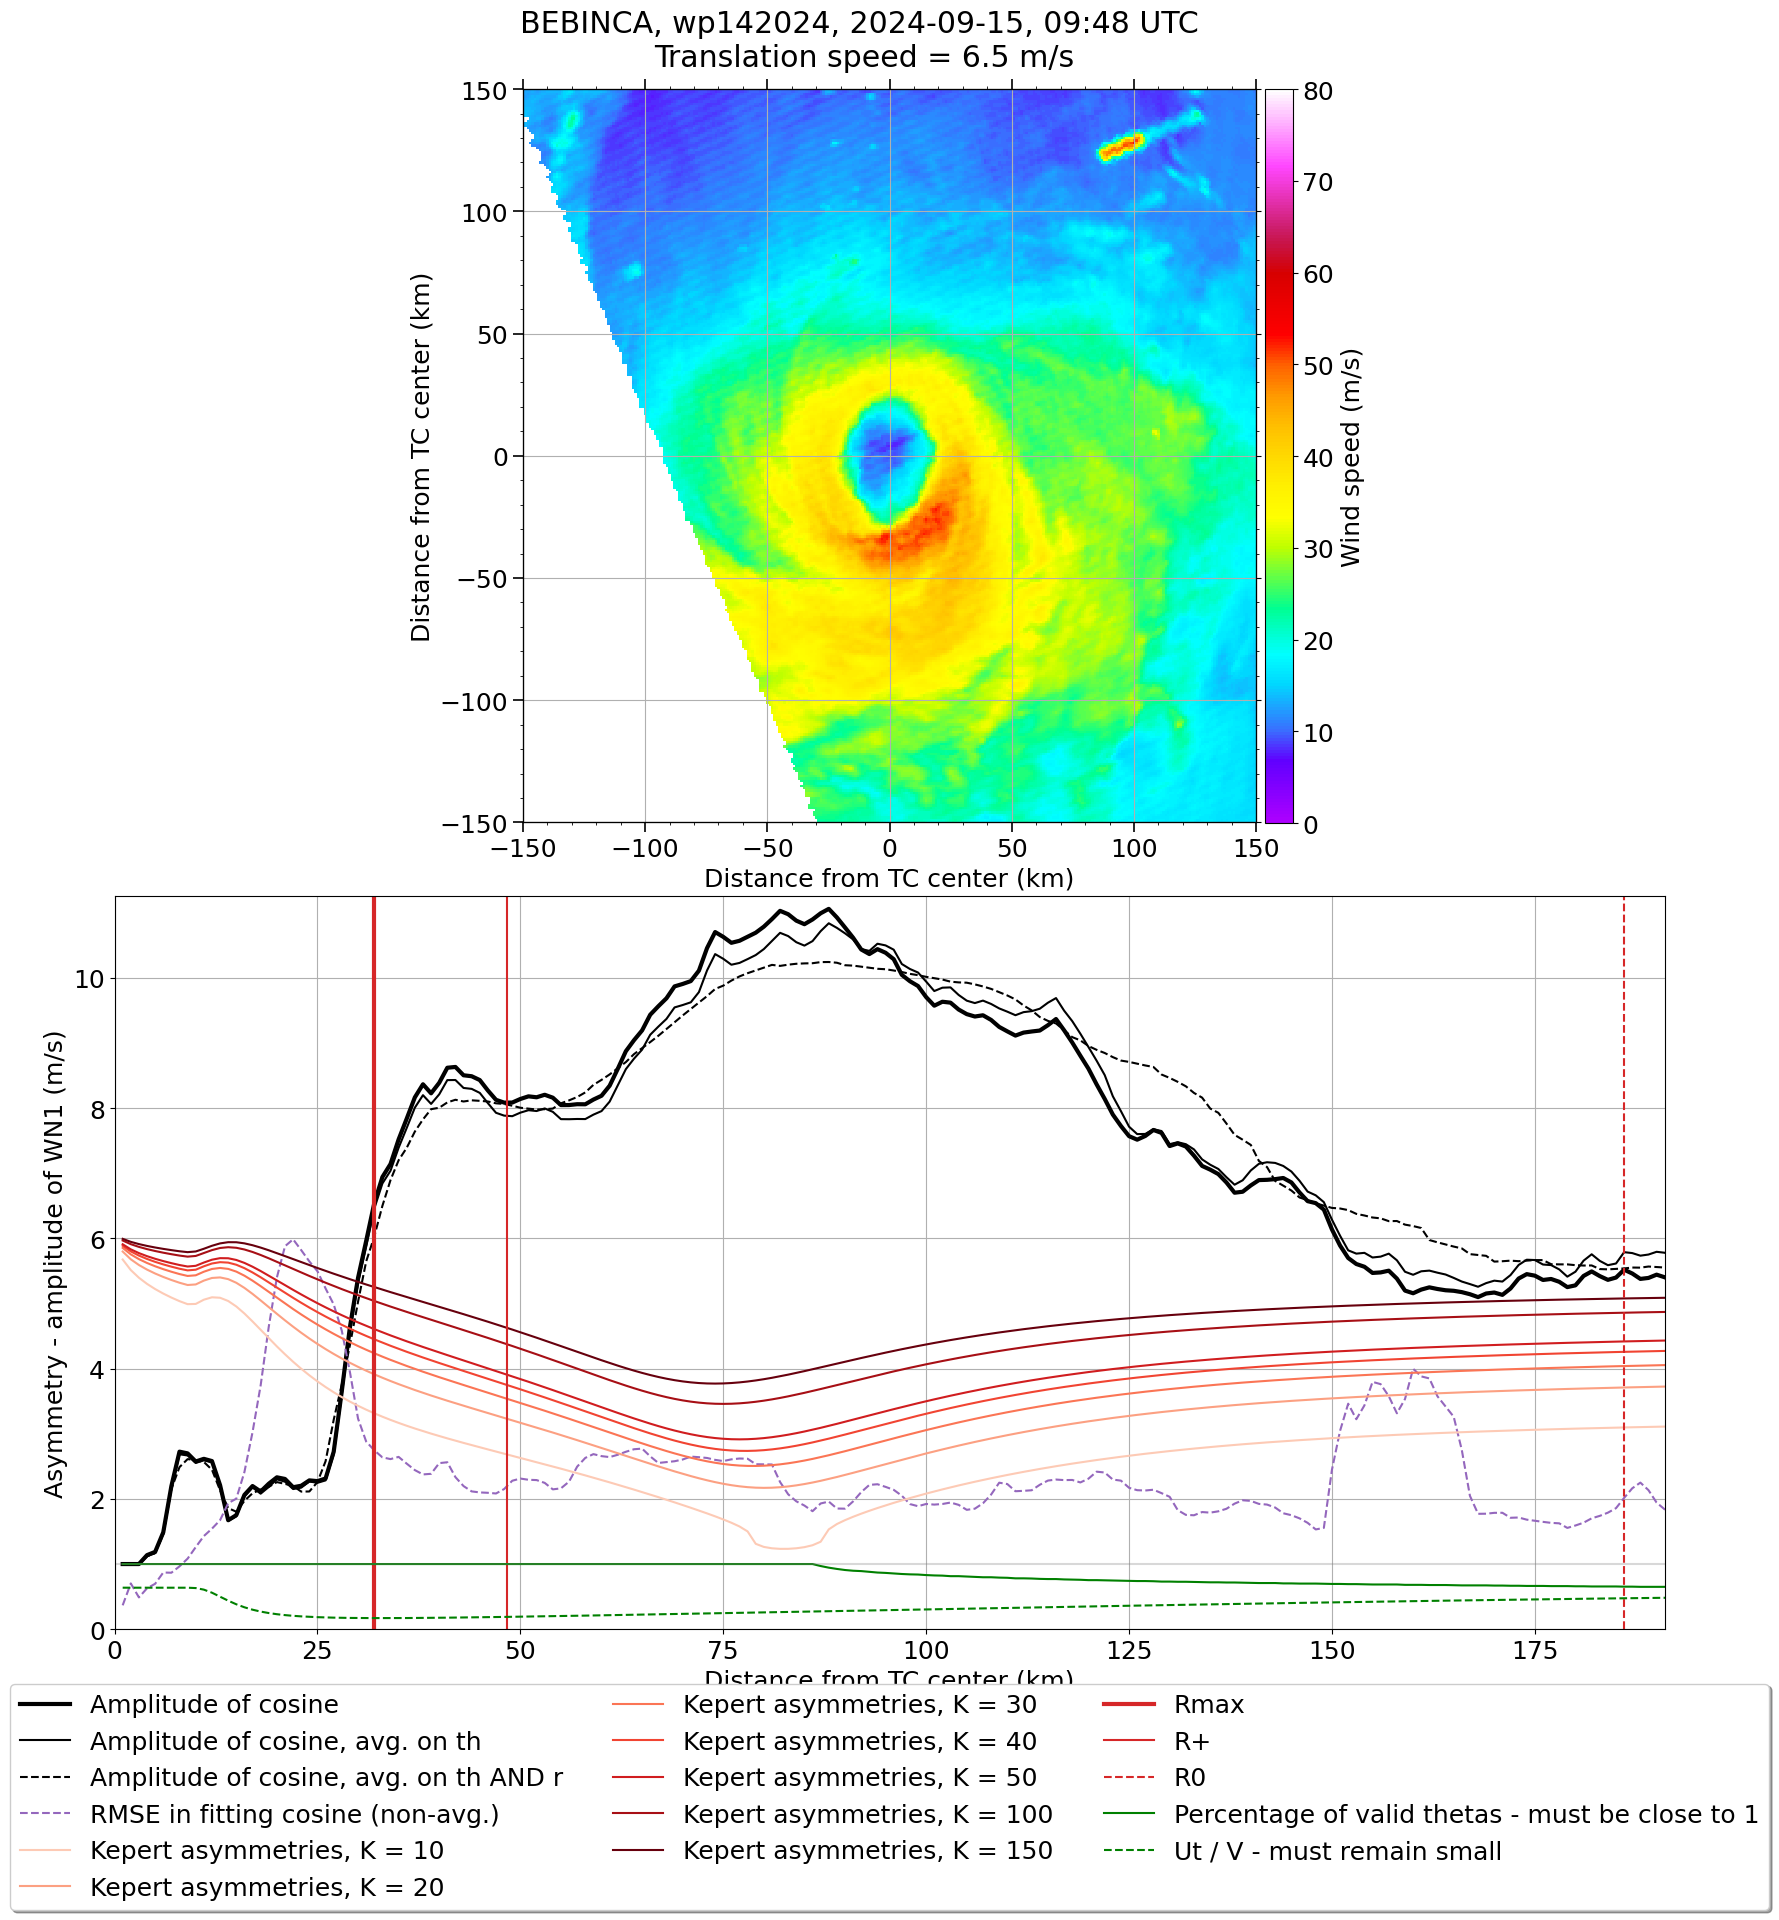

In [27]:
############
### Plot ###
############
fig          = plt.figure(figsize=(20, 20))
gs           = GridSpec(2, 1, hspace=0.1, wspace=0.01)
cmap         = mpl.cm.get_cmap('PuOr') # Spectral
normalizer   = Normalize(0, 80)
ax_lims2D    = 150
ts           = pd.to_datetime(str(ds.time.values)) 
d            = ts.strftime('%Y-%m-%d, %H:%M')
plt.suptitle('{}, {}, {} UTC \nTranslation speed = {:.1f} m/s'.format(ds.name.item(), ds.id.item(), d, ds.speed), y=0.92)

### Plot SAR
ax           = fig.add_subplot(gs[0, 0])
dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
ds_x, ds_y   = pol2cart(dr, th)
ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='linear')
im           = ax.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer)

# Axes
ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_ylabel(r'Distance from TC center (km)')
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.grid()

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=7, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Colorbar
cb_ax = fig.add_axes([0.7, 0.513, 0.014, 0.367])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(r'Wind speed (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

### Plot asymmetries (SAR + Kepert)
ax       = fig.add_subplot(gs[1, 0])

ax.plot(xs / 1000, ASS, c='k',          linewidth=3,        label='Amplitude of cosine')
ax.plot(xs / 1000, AS2, c='k',                              label='Amplitude of cosine, avg. on th')
ax.plot(xs / 1000, AS3, c='k',          linestyle='dashed', label='Amplitude of cosine, avg. on th AND r')
ax.plot(xs / 1000, ERR, c='tab:purple', linestyle='dashed', label='RMSE in fitting cosine (non-avg.)')
# ax.plot(ds.rad / 1000, ds.quantile_diff,       c='tab:blue',   linewidth=3,        label='10%-quantile difference')
# Kepert asymmetry profiles
for i, K in enumerate(Ks):
    ax.plot(xs / 1000, AKS[K],                 c=colors[i],                        label='Kepert asymmetries, K = {}'.format(K))
# Wind radii
ax.axvline(ds.rmx / 1000,                      c='tab:red',    linewidth=3,        label='Rmax')
ax.axvline(ds.rps / 1000,                      c='tab:red',                        label='R+')
ax.axvline(ds.r0 / 1000,                       c='tab:red',    linestyle='dashed', label='R0')

# # I ~ V/r
# ax.axvline(ds.I_Vr1 / 1000,                    c='orange',                         label='I ~ V/r with SAR wind speed (not BL-top)')
# ax.axvline(ds.I_Vr2 / 1000,                    c='orange')

# Validity curves
# ax.plot(xs / 1000, first_term_eq5_k01 / secnd_term_eq5_k01,      c='green',      linewidth=3,        label='Inertial ratio - must be close to 1')
ax.plot(xs / 1000, np.array(VTS) / 360., c='green',                          label='Percentage of valid thetas - must be close to 1')
ax.plot(xs / 1000, Ut / Vs[0, idxs],      c='green',      linestyle='dashed', label='Ut / V - must remain small')
ax.axhline(1, c='gray', alpha=0.3)

# Legends
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_ylabel('Asymmetry - amplitude of WN1 (m/s)')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=3, fancybox=True, shadow=True)
ax.set_xlim(0, max(float(ds.r0 / 1000) + 5, 150))
ax.set_ylim(0, 0.2 + float(max(max(ASS), max(ERR))))
ax.grid()

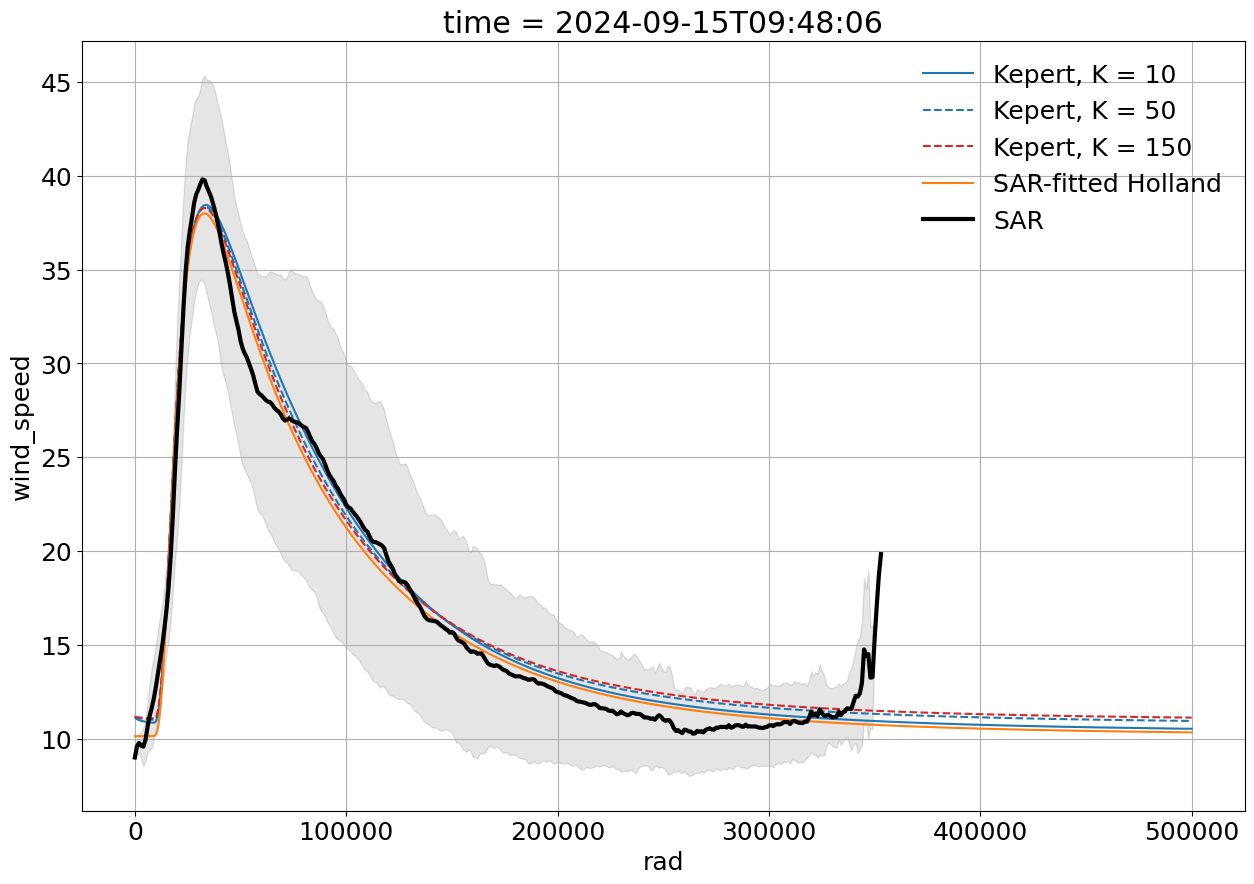

In [28]:
wsm = dsp.wind_speed.mean(dim='theta')
wss = dsp.wind_speed.std(dim='theta')

KEP_POLS[10].wind_speed.mean(dim='theta', skipna=True).plot(c='tab:blue', label='Kepert, K = 10')
KEP_POLS[50].wind_speed.mean(dim='theta', skipna=True).plot(c='tab:blue', label='Kepert, K = 50', linestyle='dashed')
KEP_POLS[150].wind_speed.mean(dim='theta', skipna=True).plot(c='tab:red', label='Kepert, K = 150', linestyle='dashed')
plt.plot(rs, V, c='tab:orange', label='SAR-fitted Holland')
wsm.plot(c='k', linewidth=3, label='SAR')
plt.fill_between(wsm.rad, wsm - wss, wsm + wss, color='k', alpha=0.1)
plt.legend(frameon=False)
plt.grid()

In [29]:
# Get Kepert
K = 50
kep_pol, kep_car = get_z_kepert(THs, Rs, ths, rs, zs, Vs, Ut, K, C, fcr)

  0%|          | 0/8 [00:00<?, ?it/s]

Polar dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

Cartesian dataset created.


In [30]:
# Obtain w
kep_pol, kep_car = get_w(kep_pol, kep_car, zs)

  0%|          | 0/8 [00:00<?, ?it/s]

In [31]:
# Get additional Kepert models
kep_pol1, kep_car1 = get_z_kepert(THs, Rs, ths, rs, zs, Vs, Ut, K / 4, C / 2, fcr)
kep_pol1, kep_car1 = get_w(kep_pol1, kep_car1, zs)

kep_pol2, kep_car2 = get_z_kepert(THs, Rs, ths, rs, zs, Vs, Ut, K * 4, C * 2, fcr)
kep_pol2, kep_car2 = get_w(kep_pol2, kep_car2, zs)

  0%|          | 0/8 [00:00<?, ?it/s]

Polar dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

Cartesian dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Polar dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

Cartesian dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

In [32]:
kep_pol3, kep_car3 = get_z_kepert(THs, Rs, ths, rs, zs, Vs, Ut, K * 4, C, fcr)
kep_pol3, kep_car3 = get_w(kep_pol3, kep_car3, zs)

  0%|          | 0/8 [00:00<?, ?it/s]

Polar dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

Cartesian dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

In [33]:
# kep_pol4, kep_car4 = get_z_kepert(THs, Rs, ths, rs, zs, Vs, Ut, K * 20, C * 100, fcr)
# kep_pol4, kep_car4 = get_w(kep_pol4, kep_car4, zs)

### EarthCARE

In [139]:
# Open EarthCARE
p  = '/home/arthur/data/earthCARE/samples/JAXA_L1B_vCa/case_corr_xCa/data/corr_xCa/ECA_J_CPR_NOM_1BS_20240915T1728_20240915T1740_01708B_vCa_corr_xCa.nc'
ec = xr.open_dataset(p)

In [140]:
# Compute TC center at EarthCARE time
subset           = ['lon', 'lat']
d_itp            = xr.concat([ds0[subset], ds[subset]], dim='time').interp(coords={'time': [np.datetime64('2024-09-15T17:31:00')]})
lon_cen, lat_cen = float(d_itp.lon), float(d_itp.lat)

/tmp/ipykernel_5376/3839443206.py:3: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  d_itp            = xr.concat([ds0[subset], ds[subset]], dim='time').interp(coords={'time': [np.datetime64('2024-09-15T17:31:00')]})


In [141]:
# For Bebinca we cannot interpolate position between 2 SAR images
# So we rely on best-track data
ds_ibt                = xr.open_dataset('/home/arthur/data/tropical_cyclones/ibtracs/24032025/IBTrACS.ALL.v04r01.nc')[['usa_lon', 'usa_lat', 'usa_atcf_id']]
ds_ibt['usa_atcf_id'] = ds_ibt['usa_atcf_id'].astype(str, copy=False) 
dsi                   = ds_ibt.where(ds_ibt.usa_atcf_id == ds.id.item().upper(), drop=True).isel(storm=0)
dsi_interp            = dsi.assign_coords({'date_time': dsi['time']}).dropna(dim='date_time', subset=['usa_lat'])[['usa_lon', 'usa_lat']].drop_indexes('date_time').interp(date_time=[np.datetime64('2024-09-15T17:31:00')])
lon_cen, lat_cen      = float(dsi_interp.usa_lon), float(dsi_interp.usa_lat)

/tmp/ipykernel_5376/1262117899.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dsi_interp            = dsi.assign_coords({'date_time': dsi['time']}).dropna(dim='date_time', subset=['usa_lat'])[['usa_lon', 'usa_lat']].drop_indexes('date_time').interp(date_time=[np.datetime64('2024-09-15T17:31:00')])


In [142]:
# Compute polar coordinates of EarthCARE
geod_wgs84        = CRS("epsg:4326").get_geod()
forward_az, _, dr = geod_wgs84.inv(np.ones_like(ec.lon) * lon_cen, np.ones_like(ec.lat) * lat_cen, ec.lon, ec.lat)
th                = get_polar_theta(forward_az) # r is dr

ec['r']           = xr.DataArray(data=dr, dims=['ray'])
ec['th']          = xr.DataArray(data=th, dims=['ray'])

In [143]:
# Select only the EC low levels and where height is valid
ec_low = ec.isel(bin=slice(-35, None))
ec_low = ec_low.where(ec_low.height > 0)

# Moving average of ~3km horizontal and average from 0 < z < 2000m
ec_low_mean = ec_low.rolling(ray=10).mean().mean(dim='bin')

Text(0, 0.5, 'Latitude (°N)')

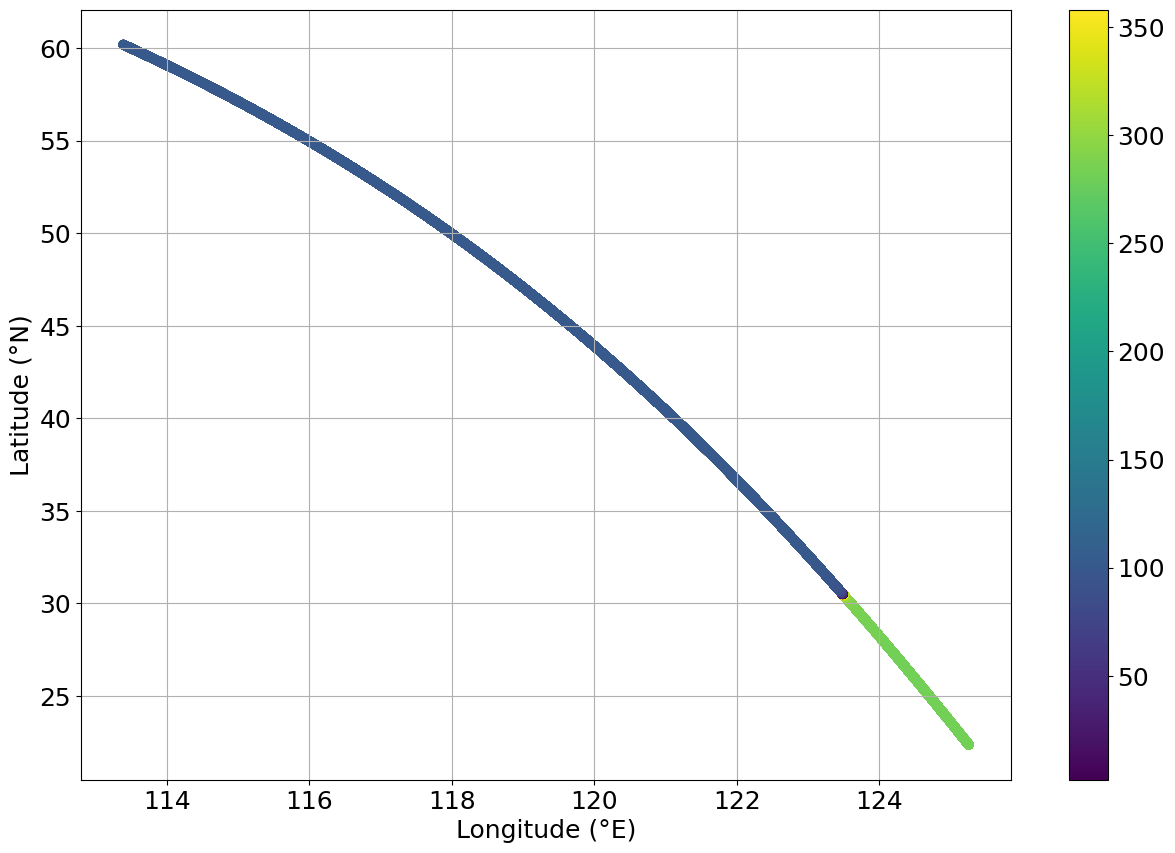

In [144]:
plt.scatter(ec_low.lon, ec_low.lat, c=ec_low.th)
plt.colorbar()
plt.grid()
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')

(array([6.00000e+01, 6.00000e+01, 8.00000e+01, 6.00000e+01, 1.20000e+02,
        1.80000e+02, 4.20000e+02, 2.56300e+03, 1.26018e+05, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 3.23740e+04, 1.90400e+03,
        3.80000e+02, 1.60000e+02, 1.20000e+02, 8.00000e+01, 6.00000e+01]),
 array([  1.93222931,  13.80044165,  25.66865398,  37.53686631,
         49.40507864,  61.27329098,  73.14150331,  85.00971564,
         96.87792797, 108.74614031, 120.61435264, 132.48256497,
        144.3507773 , 156.21898964, 168.08720197, 179.9554143 ,
        191.82362663, 203.69183897, 215.5600513 , 227.42826363,
        239.29647596, 251.1646883 , 263.03290063, 274.90111296,
        286.76932529, 298.63753763, 310.50574996, 322.37396229,
        334.24217462, 346.11038696, 357.97859929]),
 <BarContainer object of 30 artists>)

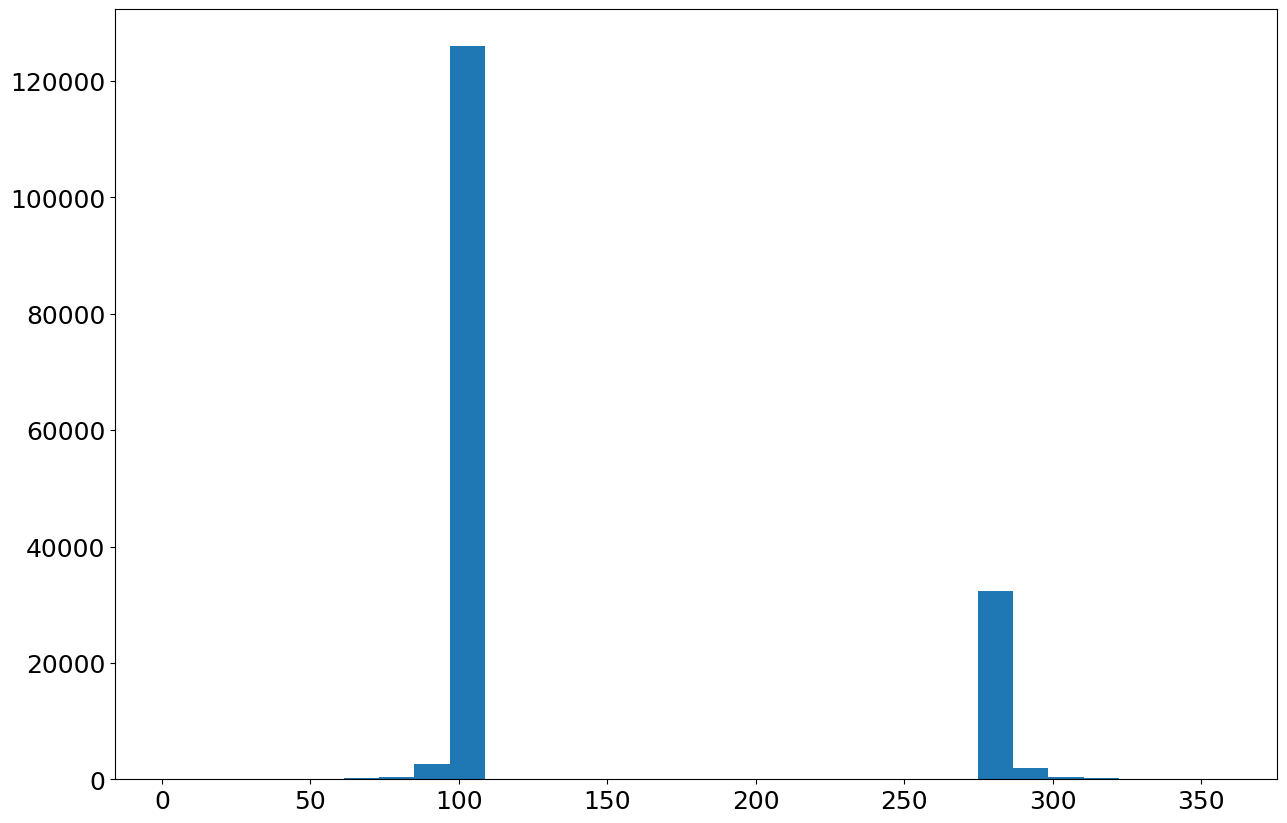

In [145]:
plt.hist(np.array(ec_low.th).flatten(), bins=30)
# plt.xlim(60, 110)

In [146]:
# Select the slice of thetas to average
# lower_th_bnd = float(ec_low.th.mean() - ec_low.th.std())
# upper_th_bnd = float(ec_low.th.mean() + ec_low.th.std())
# print(lower_th_bnd, upper_th_bnd)

lower_th_bnd1, upper_th_bnd1 = 275, 305 # Eastern side
lower_th_bnd2, upper_th_bnd2 = 80,  110 # Western side

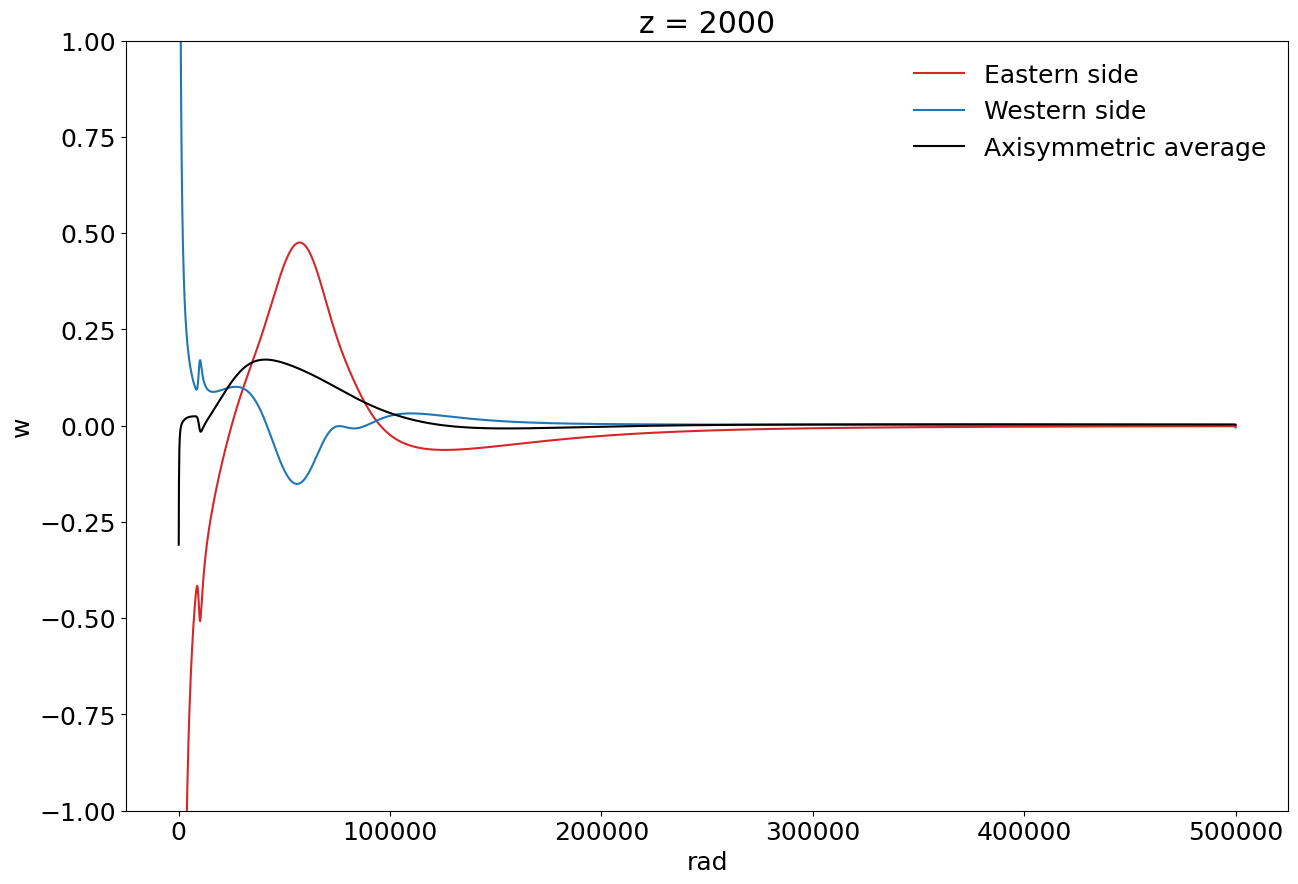

In [147]:
kep_pol.sel(z=2000, theta=slice(lower_th_bnd1, upper_th_bnd1)).mean(dim='theta').w.plot(label='Eastern side', c='tab:red')
kep_pol.sel(z=2000, theta=slice(lower_th_bnd2, upper_th_bnd2)).mean(dim='theta').w.plot(label='Western side', c='tab:blue')
kep_pol.sel(z=2000).mean(dim='theta').w.plot(label='Axisymmetric average', c='k')
plt.ylim(-1, 1)
plt.legend(frameon=False)

/tmp/ipykernel_5376/1810810245.py:14: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  cf = ax.pcolor(RS / 1000, ec.where(ec.th >= 250).height / 1000, ec.where(ec.th >= 250).reflectivity.where(mask_invalid), cmap='turbo', vmin=-35, vmax=20)
/tmp/ipykernel_5376/1810810245.py:17: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(cf, extend='both', pad=0.01)
/tmp/ipykernel_5376/1810810245.py:28: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges

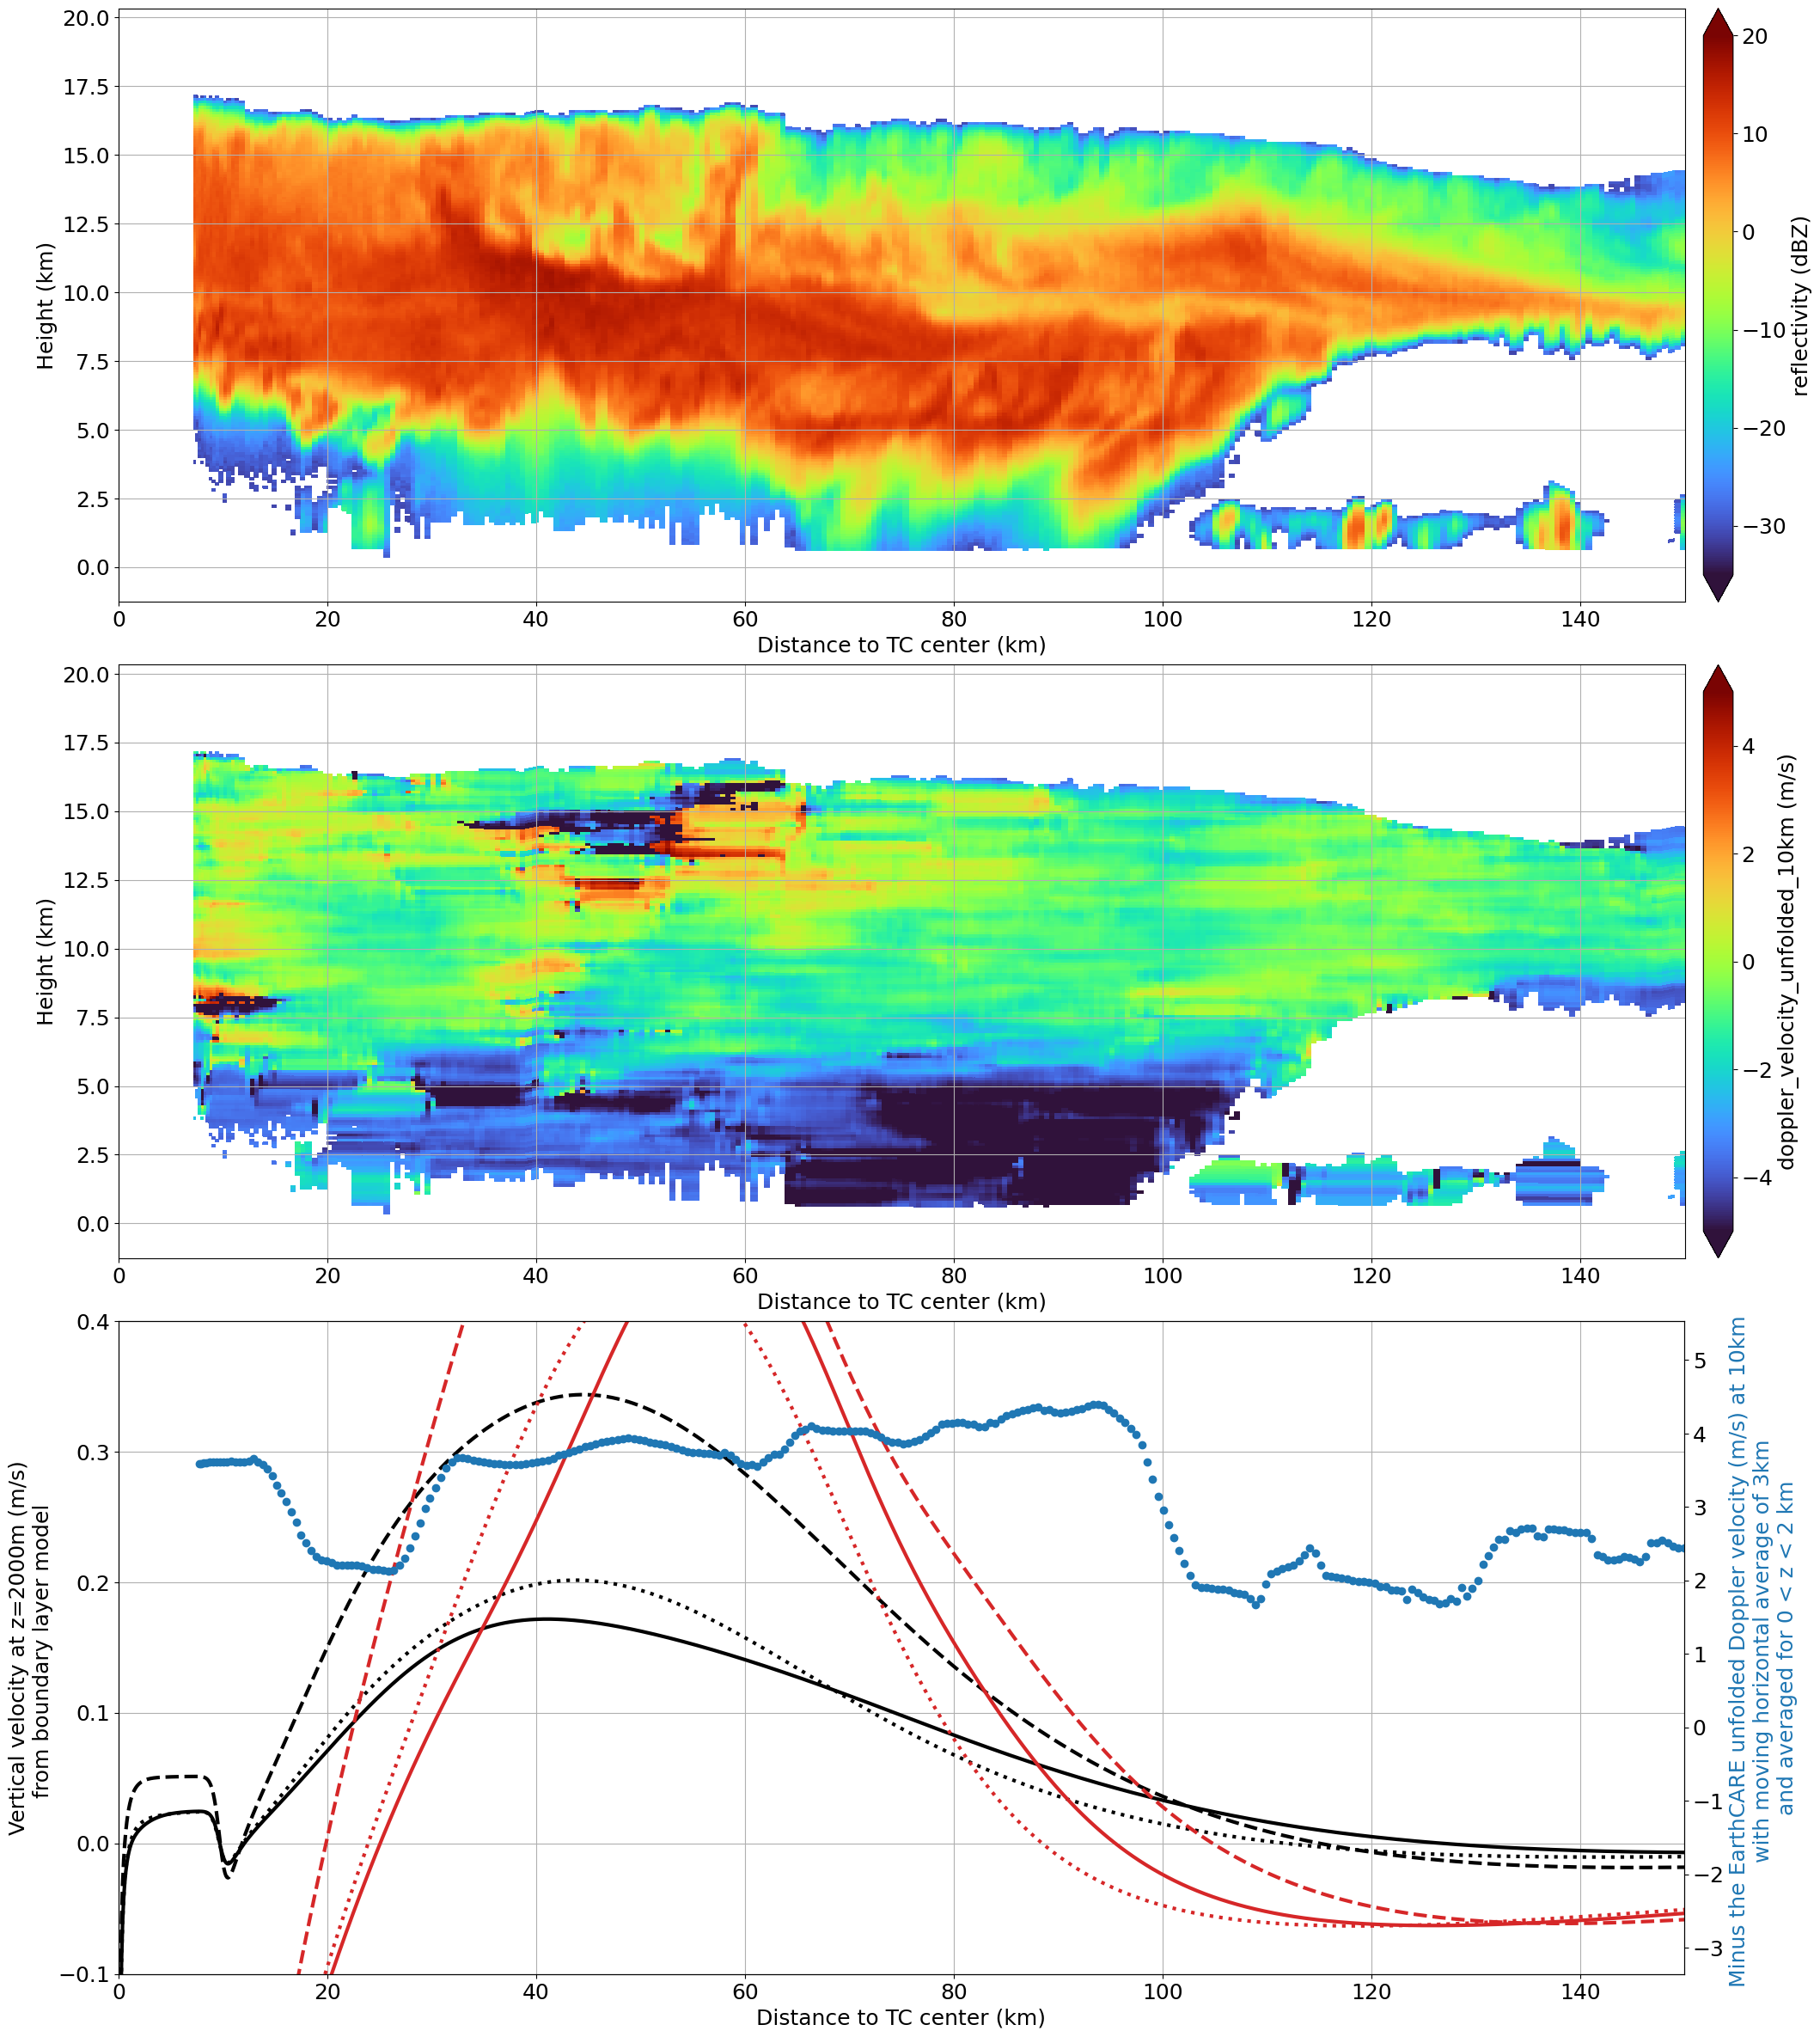

In [148]:
### FIGURE - Eastern side
fig = plt.figure(figsize = (28, 30))
gs  = GridSpec(100, 100) 

### EarthCARE - Reflectivity
ax  = fig.add_subplot(gs[:30, :])

# Prepare data
RS = np.tile(ec.r, (len(ec.bin), 1)).transpose()
# Mask
mask_invalid = np.array((ec.mask == 10))

# Plot
cf = ax.pcolor(RS / 1000, ec.where(ec.th >= 250).height / 1000, ec.where(ec.th >= 250).reflectivity.where(mask_invalid), cmap='turbo', vmin=-35, vmax=20)

# Grids
cbar = plt.colorbar(cf, extend='both', pad=0.01)
cbar.set_label(r'reflectivity (dBZ)', rotation=90)
ax.set_xlabel('Distance to TC center (km)')
ax.set_ylabel('Height (km)')
ax.grid()
ax.set_xlim(0, 150)

### EarthCARE - Vertical velocity
ax  = fig.add_subplot(gs[33:63, :])

# Plot
cf = ax.pcolor(RS / 1000, ec.where(ec.th >= 250).height / 1000, ec.where(ec.th >= 250).doppler_velocity_unfolded_10km.where(mask_invalid), cmap='turbo', vmin=-5, vmax=5)

# Grids
cbar = plt.colorbar(cf, extend='both', pad=0.01)
cbar.set_label(r'doppler_velocity_unfolded_10km (m/s)', rotation=90)
ax.set_xlabel('Distance to TC center (km)')
ax.set_ylabel('Height (km)')
ax.grid()
ax.set_xlim(0, 150)

### BL - Vertical velocity
ax  = fig.add_subplot(gs[66:99, :84])

# Plot
ax.plot(kep_pol.rad / 1000,   kep_pol.sel(z=2000).mean(dim='theta').w,   c='k', linewidth=3)
ax.plot(kep_pol2.rad / 1000,  kep_pol2.sel(z=2000).mean(dim='theta').w,  c='k', linewidth=3, linestyle='dashed')
ax.plot(kep_pol3.rad / 1000,  kep_pol3.sel(z=2000).mean(dim='theta').w,  c='k', linewidth=3, linestyle='dotted')

ax.plot(kep_pol.rad / 1000,   kep_pol.sel(z=2000, theta=slice(lower_th_bnd1, upper_th_bnd1)).mean(dim='theta').w,   c='tab:red', linewidth=3)
ax.plot(kep_pol2.rad / 1000,  kep_pol2.sel(z=2000, theta=slice(lower_th_bnd1, upper_th_bnd1)).mean(dim='theta').w,  c='tab:red', linewidth=3, linestyle='dashed')
ax.plot(kep_pol3.rad / 1000,  kep_pol3.sel(z=2000, theta=slice(lower_th_bnd1, upper_th_bnd1)).mean(dim='theta').w,  c='tab:red', linewidth=3, linestyle='dotted')

axb = ax.twinx()
axb.scatter(ec_low_mean.where(ec_low_mean.th >= 250).r / 1000, -ec_low_mean.where(ec_low_mean.th >= 250).doppler_velocity_unfolded_10km, c='tab:blue')
axb.set_ylabel('Minus the EarthCARE unfolded Doppler velocity (m/s) at 10km \nwith moving horizontal average of 3km \nand averaged for 0 < z < 2 km', c='tab:blue')


# Grids
# plt.colorbar(cf, extend='both', pad=0.01)
ax.set_xlabel('Distance to TC center (km)')
ax.set_ylabel('Vertical velocity at z=2000m (m/s)\nfrom boundary layer model ')
ax.grid()
ax.set_ylim(-0.1, 0.4)
ax.set_xlim(0, 150)

# plt.savefig('/home/arthur/results/TCsLifeMonitFromObs/winddirection/Tests/EarthCARE/' + 'bebinca_East', bbox_inches='tight')

/tmp/ipykernel_5376/4066083927.py:14: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  cf = ax.pcolor(RS / 1000, ec.where(ec.th <= 250).height / 1000, ec.where(ec.th <= 250).reflectivity.where(mask_invalid), cmap='turbo', vmin=-35, vmax=20)
/tmp/ipykernel_5376/4066083927.py:17: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(cf, extend='both', pad=0.01)
/tmp/ipykernel_5376/4066083927.py:28: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges

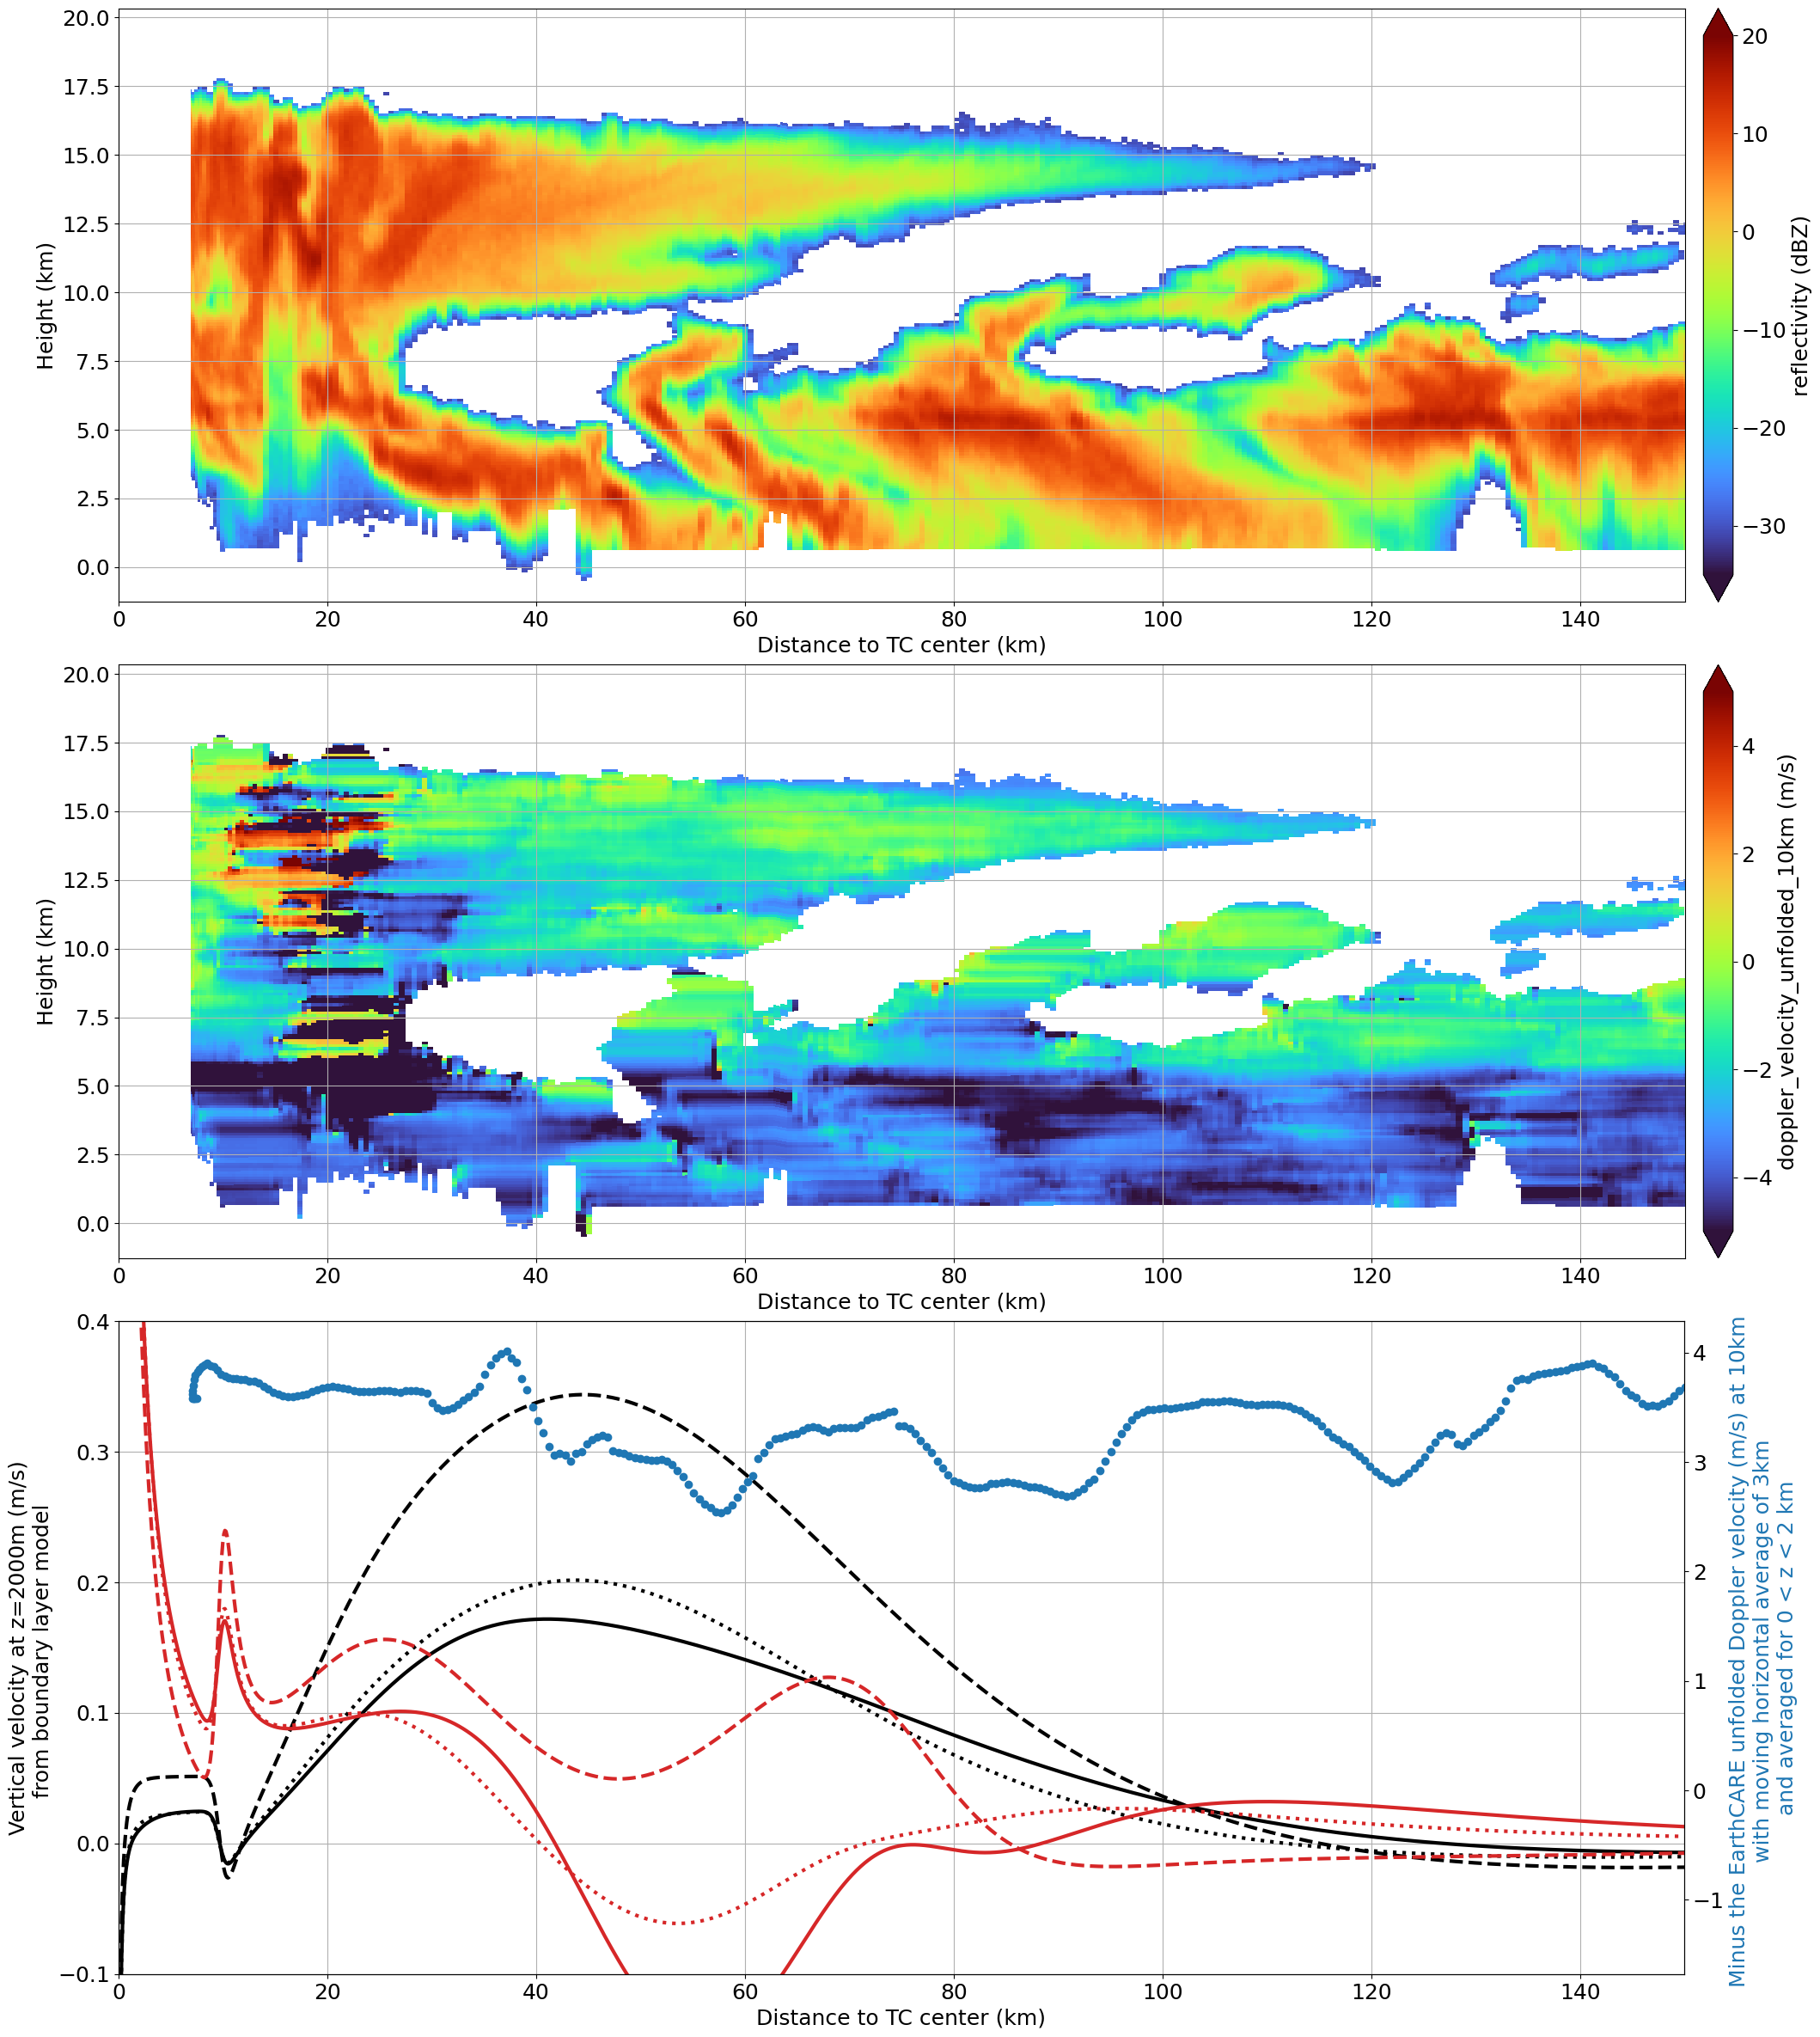

In [149]:
### FIGURE - Eastern side
fig = plt.figure(figsize = (28, 30))
gs  = GridSpec(100, 100) 

### EarthCARE - Reflectivity
ax  = fig.add_subplot(gs[:30, :])

# Prepare data
RS = np.tile(ec.r, (len(ec.bin), 1)).transpose()
# Mask
mask_invalid = np.array((ec.mask == 10))

# Plot
cf = ax.pcolor(RS / 1000, ec.where(ec.th <= 250).height / 1000, ec.where(ec.th <= 250).reflectivity.where(mask_invalid), cmap='turbo', vmin=-35, vmax=20)

# Grids
cbar = plt.colorbar(cf, extend='both', pad=0.01)
cbar.set_label(r'reflectivity (dBZ)', rotation=90)
ax.set_xlabel('Distance to TC center (km)')
ax.set_ylabel('Height (km)')
ax.grid()
ax.set_xlim(0, 150)

### EarthCARE - Vertical velocity
ax  = fig.add_subplot(gs[33:63, :])

# Plot
cf = ax.pcolor(RS / 1000, ec.where(ec.th <= 250).height / 1000, ec.where(ec.th <= 250).doppler_velocity_unfolded_10km.where(mask_invalid), cmap='turbo', vmin=-5, vmax=5)

# Grids
cbar = plt.colorbar(cf, extend='both', pad=0.01)
cbar.set_label(r'doppler_velocity_unfolded_10km (m/s)', rotation=90)
ax.set_xlabel('Distance to TC center (km)')
ax.set_ylabel('Height (km)')
ax.grid()
ax.set_xlim(0, 150)

### BL - Vertical velocity
ax  = fig.add_subplot(gs[66:99, :84])

# Plot
ax.plot(kep_pol.rad / 1000,   kep_pol.sel(z=2000).mean(dim='theta').w,   c='k', linewidth=3)
ax.plot(kep_pol2.rad / 1000,  kep_pol2.sel(z=2000).mean(dim='theta').w,  c='k', linewidth=3, linestyle='dashed')
ax.plot(kep_pol3.rad / 1000,  kep_pol3.sel(z=2000).mean(dim='theta').w,  c='k', linewidth=3, linestyle='dotted')

ax.plot(kep_pol.rad / 1000,   kep_pol.sel(z=2000, theta=slice(lower_th_bnd2, upper_th_bnd2)).mean(dim='theta').w,   c='tab:red', linewidth=3)
ax.plot(kep_pol2.rad / 1000,  kep_pol2.sel(z=2000, theta=slice(lower_th_bnd2, upper_th_bnd2)).mean(dim='theta').w,  c='tab:red', linewidth=3, linestyle='dashed')
ax.plot(kep_pol3.rad / 1000,  kep_pol3.sel(z=2000, theta=slice(lower_th_bnd2, upper_th_bnd2)).mean(dim='theta').w,  c='tab:red', linewidth=3, linestyle='dotted')


theta=slice(lower_th_bnd1, upper_th_bnd1)

axb = ax.twinx()
axb.scatter(ec_low_mean.where(ec_low_mean.th <= 250).r / 1000, -ec_low_mean.where(ec_low_mean.th <= 250).doppler_velocity_unfolded_10km, c='tab:blue')
axb.set_ylabel('Minus the EarthCARE unfolded Doppler velocity (m/s) at 10km \nwith moving horizontal average of 3km \nand averaged for 0 < z < 2 km', c='tab:blue')


# Grids
# plt.colorbar(cf, extend='both', pad=0.01)
ax.set_xlabel('Distance to TC center (km)')
ax.set_ylabel('Vertical velocity at z=2000m (m/s)\nfrom boundary layer model ')
ax.grid()
ax.set_ylim(-0.1, 0.4)
ax.set_xlim(0, 150)

# plt.savefig('/home/arthur/results/TCsLifeMonitFromObs/winddirection/Tests/EarthCARE/' + 'bebinca_West', bbox_inches='tight')